# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com algumas camadas escondidas.


## Importação dos pacotes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR

import lib.pytorch_trainer_v2 as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [3]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [4]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [5]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer2(x)
        x = nn.functional.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer3(x)
        x = nn.functional.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer4(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model(
  (layer1): Linear(in_features=13, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=1, bias=True)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.7)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [9]:
trainer.fit(50, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=2)

Start training for 50 epochs
  1:   0.5s   T: 156.04656 *   V: 6.71998 *  
  2:   0.2s   T: 18.95616 *   V: 6.98194    
  3:   0.3s   T: 17.36549 *   V: 6.12331 *  
  4:   0.3s   T: 15.77428 *   V: 5.62210 *  
  5:   0.3s   T: 14.76643 *   V: 5.86391    
  6:   0.2s   T: 14.07846 *   V: 5.64006    
  7:   0.3s   T: 13.28713 *   V: 5.44351 *  
  8:   0.3s   T: 13.01907 *   V: 6.32169    
  9:   0.2s   T: 12.74608 *   V: 6.07890    
 10:   0.3s   T: 12.40032 *   V: 4.99576 *  
 11:   0.3s   T: 11.48492 *   V: 5.65089    
 12:   0.2s   T: 11.43213 *   V: 4.55960 *  
 13:   0.2s   T: 11.31665 *   V: 4.93928    
 14:   0.2s   T: 10.70446 *   V: 4.23102 *  
 15:   0.2s   T: 10.49471 *   V: 3.87195 *  
 16:   0.2s   T: 10.12999 *   V: 4.15201    
 17:   0.3s   T: 10.19280     V: 3.61108 *  
 18:   0.2s   T: 9.63418 *   V: 3.66942    
 19:   0.2s   T: 9.46021 *   V: 4.06815    
 20:   0.2s   T: 9.35749 *   V: 3.62842    
 21:   0.2s   T: 8.98910 *   V: 3.78351    
 22:   0.2s   T: 8.98738 *   

## Avaliação

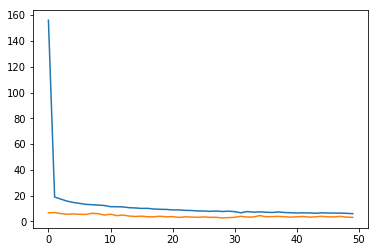

In [10]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [11]:
trainer.load_state('../../models/bostonhousing')

In [12]:
eval = trainer.evaluate(x_train,y_train)
eval

evaluate: 50/50 ok


{'losses': [1.4666555229383025]}

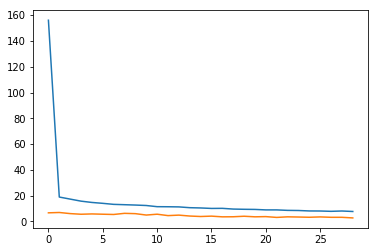

In [13]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [14]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 2.7733680120862947
RMSE: 1.6653432114991475


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
